In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

# Define the skewed Bernoulli map and its derivative
def f_SB(x, b):
    return np.where(x <= 1/b, b * x, (b * x - 1) / (b - 1))

def df_SB(x, b):
    return np.where(x <= 1/b, b, b / (b - 1))


In [ ]:
def evolve_system(y, v, epsilon, b):
    N = len(y)
    y_mean = np.mean(y)
    input_y = (1 - epsilon) * y + epsilon * y_mean
    y_next = f_SB(input_y, b)

    v_mean = np.mean(v)
    input_v = (1 - epsilon) * v + epsilon * v_mean
    f_prime = df_SB(input_y, b)
    v_next = f_prime * input_v

    return y_next, v_next

def compute_lyapunov(N, b=4.0, epsilon=0.02, T_trans=2000, T_lyap=10000):
    y = np.random.rand(N).astype(np.float64)
    v = np.random.rand(N).astype(np.float64)
    v /= np.linalg.norm(v)

    # Burn-in period
    for _ in range(T_trans):
        y, v = evolve_system(y, v, epsilon, b)
        v /= np.linalg.norm(v)

    le_sum = 0.0
    for _ in range(T_lyap):
        y, v = evolve_system(y, v, epsilon, b)
        norm_v = np.linalg.norm(v)
        le_sum += np.log(norm_v)
        v /= norm_v

    return le_sum / T_lyap

In [ ]:
def compute_lyapunov_avg(args):
    N, b, epsilon, T_trans, T_lyap, trials = args
    return np.mean([
        compute_lyapunov(N, b, epsilon, T_trans, T_lyap)
        for _ in range(trials)
    ])

In [ ]:
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot


In [ ]:
def simulate_and_plot(N_list, b=4.0, epsilon=0.02, trials=5, T_trans=2000, T_lyap=10000, save_path="lyap_data.npz"):
    args = [(N, b, epsilon, T_trans, T_lyap, trials) for N in N_list]

    with Pool() as pool:
        lambda_list = pool.map(compute_lyapunov_avg, args)

    lambda_array = np.array(lambda_list)
    lambda_inf = np.mean(lambda_array[-3:])  # average of largest 3 N

    # Data for Plot 1: λ(N) vs 1 / ln(N)
    x1 = 1 / np.log(N_list)
    y1 = lambda_array
    coeffs1 = np.polyfit(x1, y1, 1)
    y1_fit = np.polyval(coeffs1, x1)
    r2_1 = r2_score(y1, y1_fit)

    # Data for Plot 2: ln(λ∞ - λ(N)) vs ln(N)
    x2 = np.log(N_list)
    delta = np.abs(lambda_inf - lambda_array) + 1e-12
    y2 = np.log(delta)
    coeffs2 = np.polyfit(x2, y2, 1)
    y2_fit = np.polyval(coeffs2, x2)
    r2_2 = r2_score(y2, y2_fit)
    gamma = -coeffs2[0]

    # Data for Plot 3: λ(N) vs N (linear scale)
    x3 = N_list
    y3 = lambda_array

    # Save all data to .npz for later reuse
    np.savez(save_path,
             N_list=N_list,
             lambda_array=lambda_array,
             lambda_inf=lambda_inf,
             gamma=gamma,
             r2_1=r2_1,
             r2_2=r2_2,
             x1=x1, y1=y1, y1_fit=y1_fit,
             x2=x2, y2=y2, y2_fit=y2_fit,
             x3=x3, y3=y3)

    # Plot all three subplots
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(x1, y1, 'bo', label='Data')
    plt.plot(x1, y1_fit, 'g--', label='Fit')
    plt.xlabel('1 / ln(N)')
    plt.ylabel('λ(N)')
    plt.title(f'Logarithmic Fit\n$R^2$ = {r2_1:.4f}')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(x2, y2, 'bo', label='Data')
    plt.plot(x2, y2_fit, 'g--', label='Fit')
    plt.xlabel('ln(N)')
    plt.ylabel('ln(λ∞ - λ(N))')
    plt.title(f'Power-law Fit, γ ≈ {gamma:.2f}\n$R^2$ = {r2_2:.4f}')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(x3, y3, 'bo-', label='λ(N) vs N')
    plt.xlabel('N')
    plt.ylabel('λ(N)')
    plt.title('Lyapunov Exponent vs System Size N')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return lambda_array, gamma, r2_1, r2_2

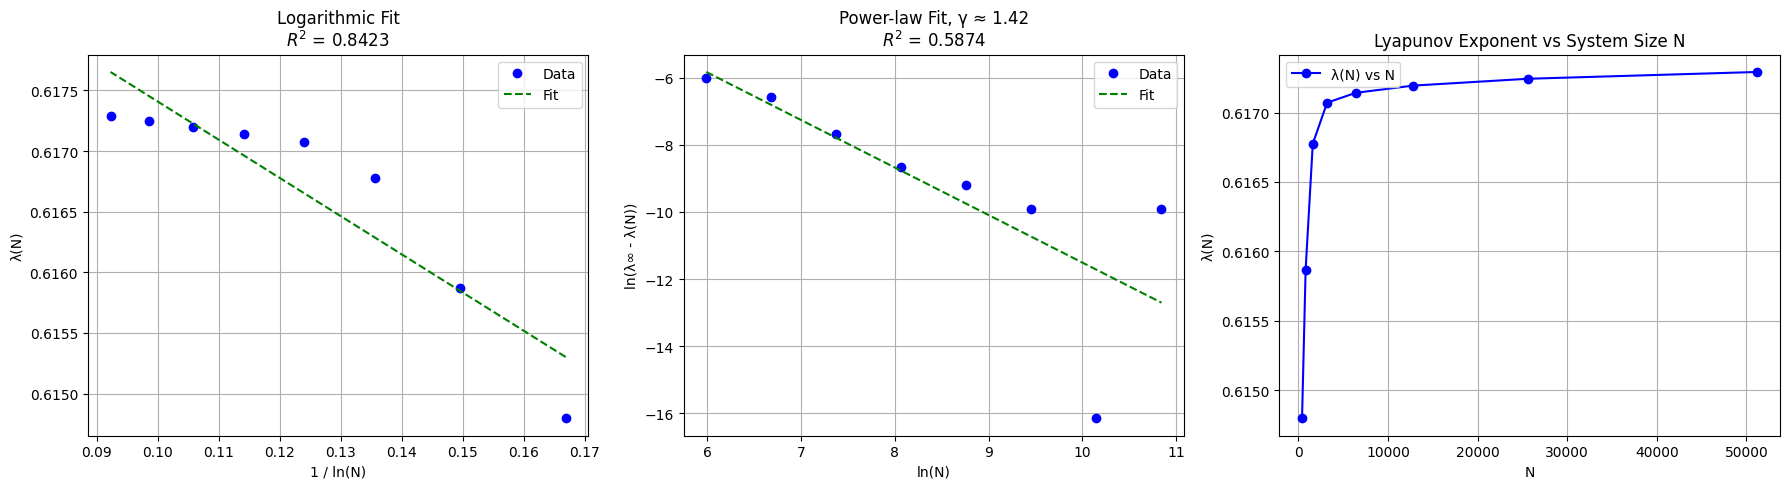

(array([0.61479595, 0.61586804, 0.6167766 , 0.61707173, 0.61714276,
        0.61719462, 0.61724388, 0.61729285]),
 np.float64(1.4161215607567639),
 np.float64(0.8423043920027542),
 np.float64(0.5874166698454232))

In [ ]:
N_list = [400, 800, 1600, 3200, 6400, 12800, 25600, 51200]
simulate_and_plot(N_list, epsilon=0.1313, trials=5, save_path="lyap_peak1.npz")

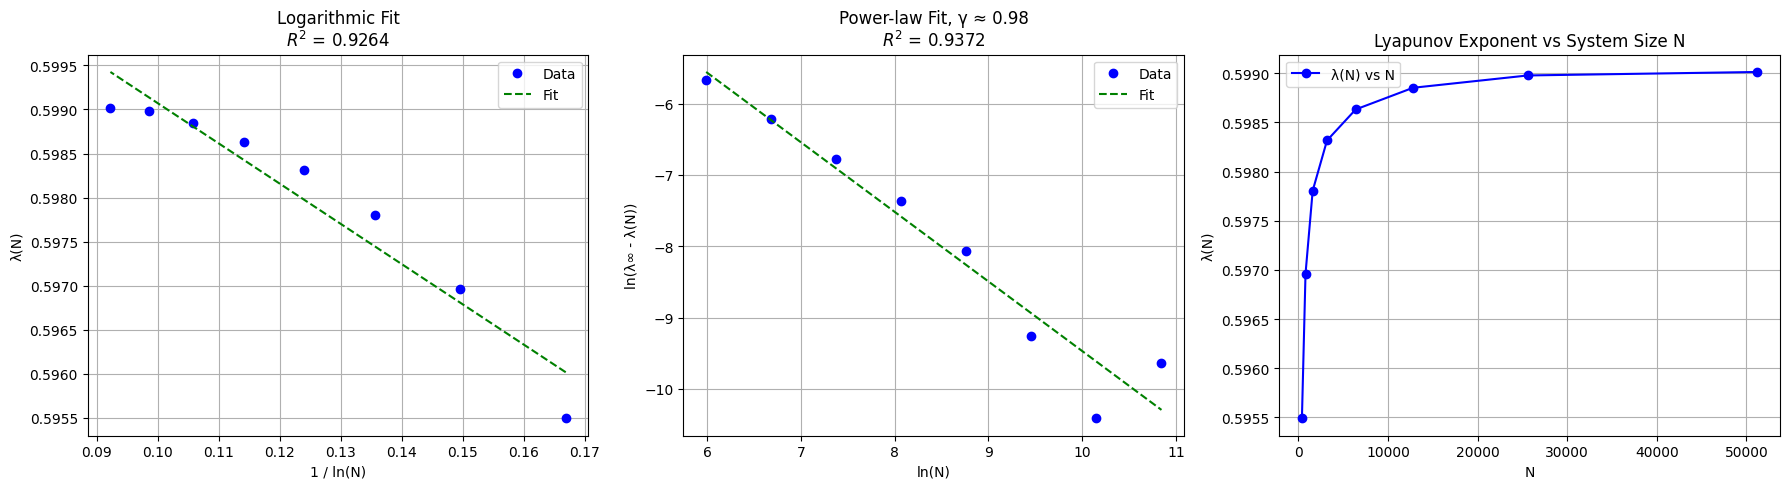

(array([0.59549065, 0.5969605 , 0.59780516, 0.59831667, 0.59863193,
        0.5988522 , 0.59897746, 0.59901283]),
 np.float64(0.9771854465966725),
 np.float64(0.9264144599013534),
 np.float64(0.9372170442757389))

In [ ]:
N_list = [400, 800, 1600, 3200, 6400, 12800, 25600, 51200]
simulate_and_plot(N_list, epsilon=0.2373, trials=5, save_path="lyap_peak2.npz")

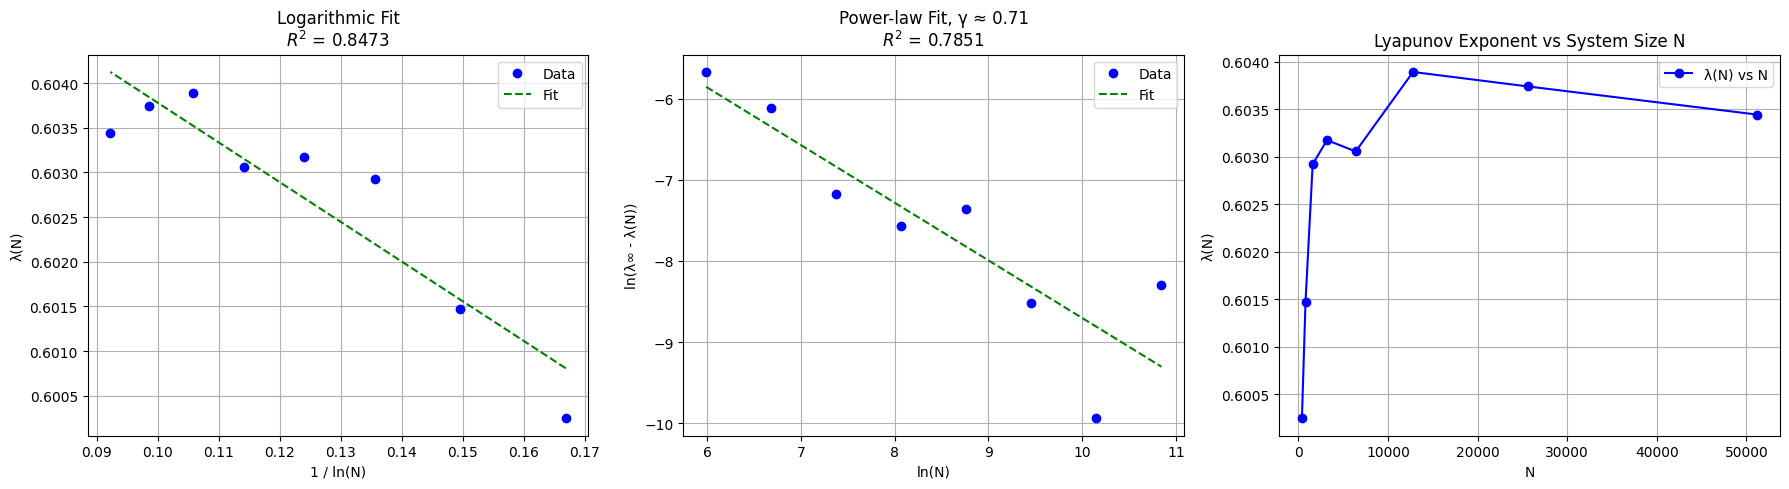

(array([0.6002456 , 0.60147012, 0.60292156, 0.60317454, 0.60305534,
        0.60389181, 0.60373975, 0.60344335]),
 np.float64(0.7111961176193865),
 np.float64(0.8473411724893496),
 np.float64(0.785066212508919))

In [ ]:
simulate_and_plot(N_list, epsilon=0.3686, trials=5, save_path="lyap_peak3.npz")

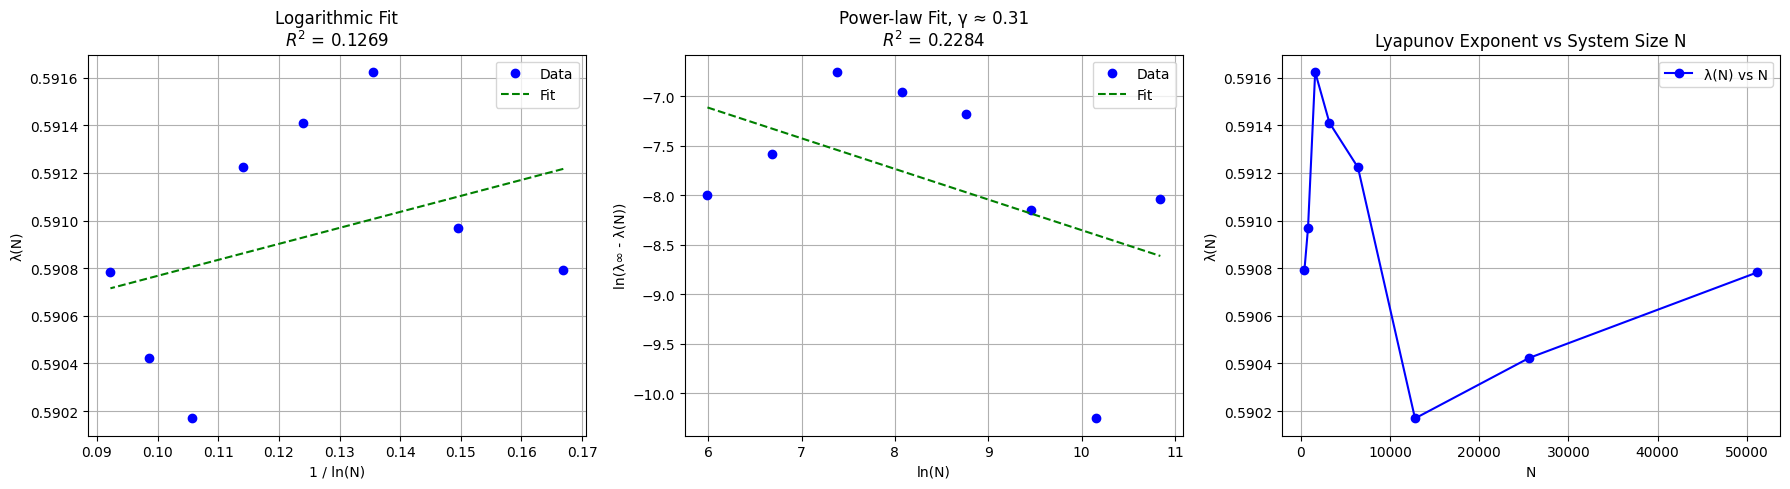

(array([0.59079316, 0.59096931, 0.59162344, 0.59141023, 0.59122267,
        0.59016958, 0.59042328, 0.5907825 ]),
 np.float64(0.3092990968615352),
 np.float64(0.12688278490553417),
 np.float64(0.22835972278448857))

In [ ]:
simulate_and_plot(N_list, epsilon=0.4242, trials=5, save_path="lyap_peak4.npz")

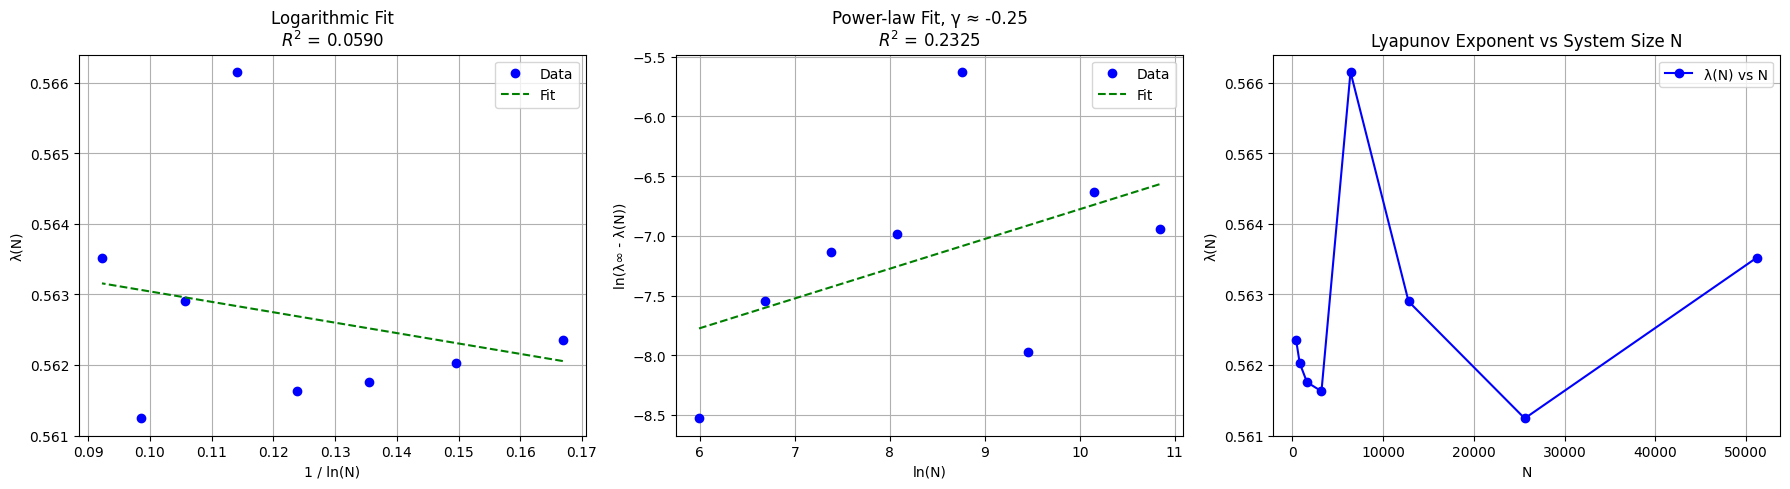

(array([0.56235712, 0.56202753, 0.56175619, 0.56162743, 0.56615   ,
        0.56289933, 0.56124333, 0.56352165]),
 np.float64(-0.24908142648386097),
 np.float64(0.059039345186769676),
 np.float64(0.2324766488914789))

In [ ]:
N_list = [400, 800, 1600, 3200, 6400, 12800, 25600, 51200]
simulate_and_plot(N_list, epsilon=0.4444, trials=5, save_path="lyap_peak5.npz")

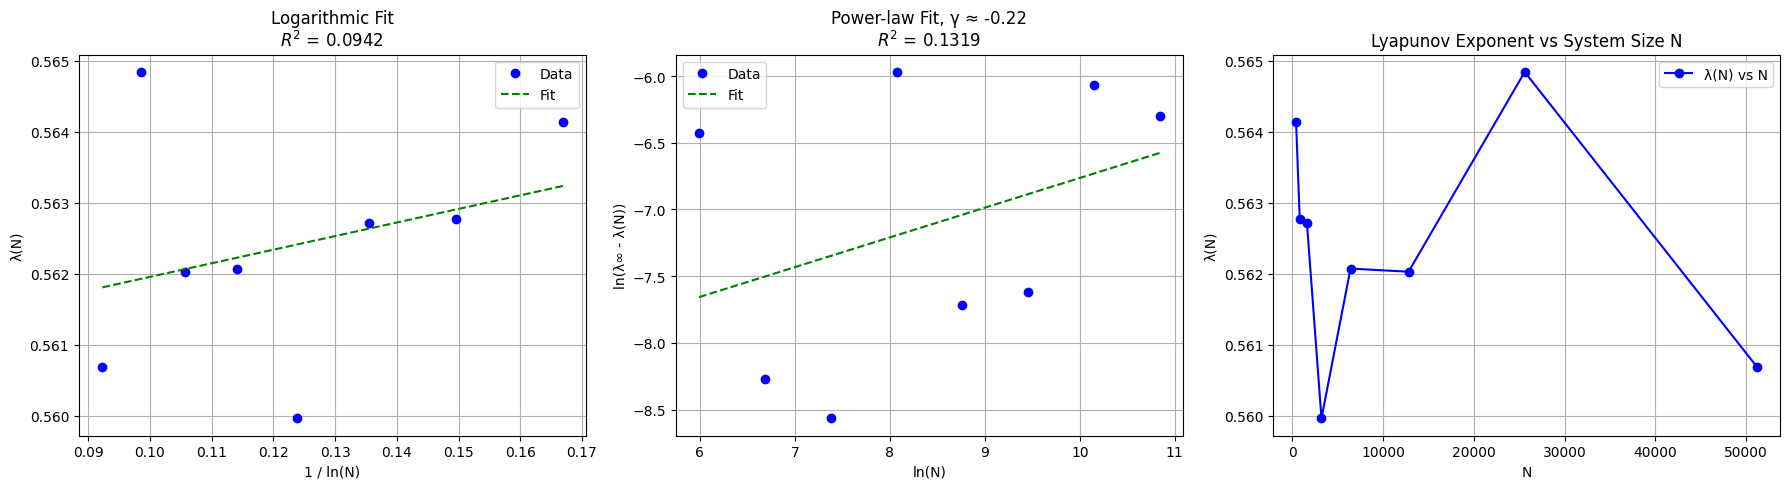

(array([0.56413687, 0.56277459, 0.56270867, 0.55996214, 0.56207148,
        0.56202753, 0.56483998, 0.56068723]),
 np.float64(-0.22286969802957646),
 np.float64(0.09417272253390763),
 np.float64(0.1319017689278269))

In [ ]:
N_list = [400, 800, 1600, 3200, 6400, 12800, 25600, 51200]
simulate_and_plot(N_list, epsilon=0.4848, trials=5, save_path="lyap_peak6.npz")

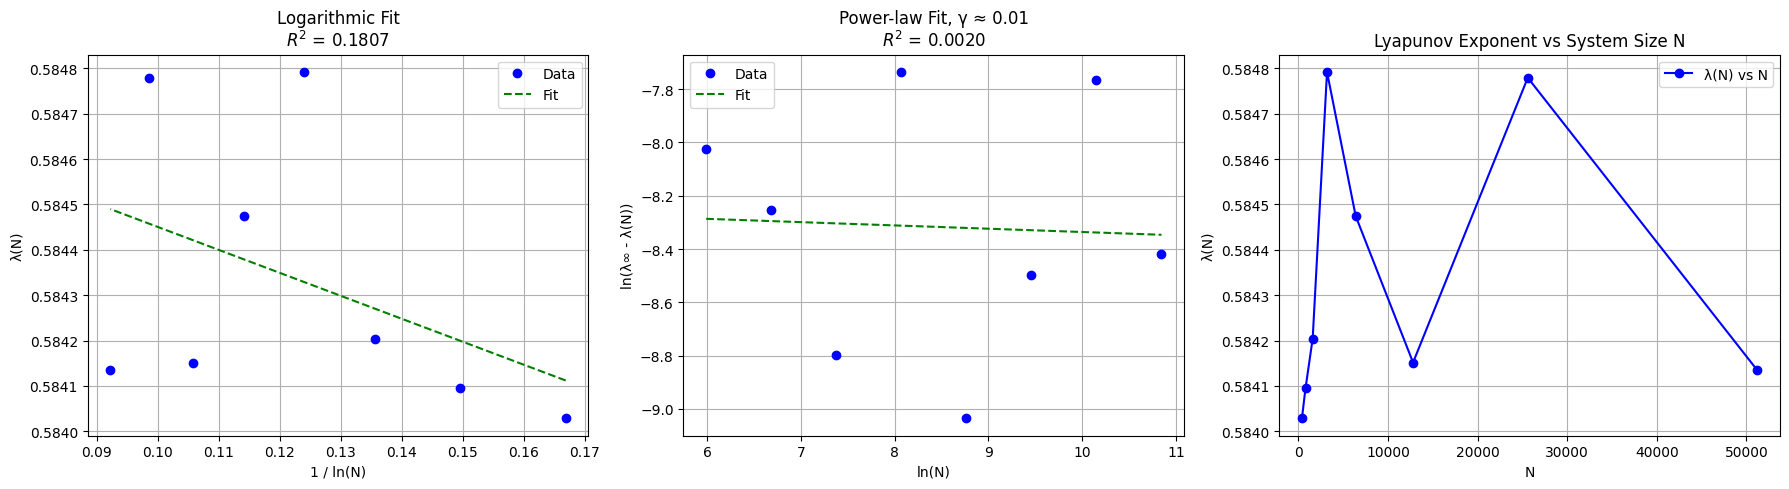

(array([0.58402826, 0.58409463, 0.58420432, 0.58479221, 0.58447434,
        0.58415149, 0.58477947, 0.58413468]),
 np.float64(0.012346143856134093),
 np.float64(0.18065235090273168),
 np.float64(0.0020191876731093794))

In [ ]:
simulate_and_plot(N_list, epsilon=0.3939, trials=5, save_path="lyap_peak7.npz")